In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(r'C:\Users\bhavi\OneDrive\Desktop\Jupyter Data\anand-vihar, delhi, delhi, india-air-quality.csv', parse_dates=['date'], index_col = 0)
df.head(5)

,pm25,pm10,o3,no2,so2,co
date,,,,,,
2022-11-02,344,424,10,49,5,11
2022-11-03,323,565,15,54,8,19
2022-11-04,414,487,9,46,7,15
2022-11-05,376,183,11,34,7,13
2022-11-06,227,169,17,43,11,14


In [3]:
df.describe()

,pm25,pm10,o3,no2,so2,co
count,3050,3050,3050,3050,3050,3050
unique,446,678,130,108,43,70
top,,,8,,5,
freq,91,122,125,131,258,200


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3050 entries, 2022-11-02 to 2021-08-01
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0    pm25   3050 non-null   object
 1    pm10   3050 non-null   object
 2    o3     3050 non-null   object
 3    no2    3050 non-null   object
 4    so2    3050 non-null   object
 5    co     3050 non-null   object
dtypes: object(6)
memory usage: 166.8+ KB


In [5]:
df.shape

(3050, 6)

In [6]:
# remove whitepsace in the column
df.columns = df.columns.str.strip()

#get the rows with the numbers (some of them where whitespaces)
s = df['pm25'].str.extract('(\w+)')[0]

#rolling average for monthly data

s_monthly = s.rolling(int((52*7)/12)).mean()

#remove missing dates
s_monthly = s_monthly.dropna()

#fill missing dates by linear interpolation
s_monthly = s_monthly.interpolate(method='linear')

#sorting the index to later make a reasonable plot
s_monthly = s_monthly.sort_index()

#aggregate the information by month
s_monthly = s_monthly.to_period('M').groupby('date').mean()

#process a timestamp to avoid errors with statsmodels' functions
s_monthly = s_monthly.to_timestamp()

#setting freq to avoid errors with statsmodels' functions
s_monthly = s_monthly.asfreq('MS').interpolate()

#change the name of the pandas.Series
#s_monthly = 'air pollution pm25'

In [7]:
s_monthly

date
2014-01-01    284.525641
2014-02-01    284.556410
2014-03-01    202.933333
2014-04-01    202.183951
2014-05-01    206.342593
                 ...    
2022-07-01    114.832258
2022-08-01    115.444086
2022-09-01    171.818889
2022-10-01    176.766667
2022-11-01    189.466667
Freq: MS, Name: 0, Length: 107, dtype: float64

<AxesSubplot:xlabel='date'>

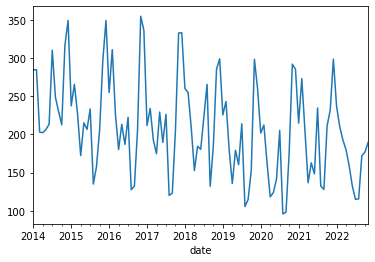

In [8]:
s_monthly.plot()

In [9]:
#Autoregressive integrated moving average model (ARIMA)
from statsmodels.tsa.arima.model import ARIMA

In [10]:
#use of ADF test to reject the null hypothesis about data is non-stationary
from statsmodels.tsa.stattools import adfuller

result = adfuller(s_monthly)

In [11]:
# The p-value is given by the second element the function adfuller returns
result[1]

0.4728135021741297

In [12]:
# The p-value is greater than 0.05. Therefore, we can't reject the null hypothesis.
# we can differentiate the Time Series by one lag and test again

s_monthly_diff1 = s_monthly.diff().dropna()
result1 = adfuller(s_monthly_diff1)
result1[1]

4.065190683276499e-24

We can reject the null hypothesis and say that our data is stationary with a lag of 1. Therefore, we need to set d:1 in the order parameter of the ARIMA() class.

Autocorrelation Plot

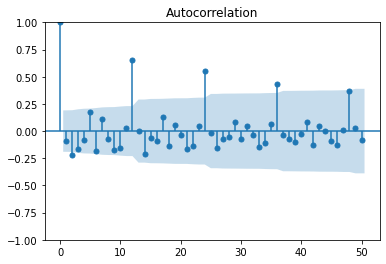

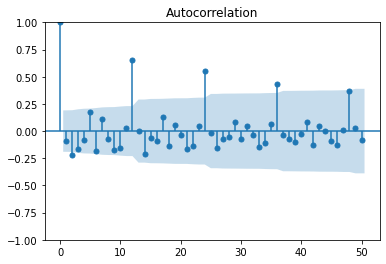

In [13]:
# Now we need to determine q based on the first significant lag of the autocorrelation plot

from statsmodels.graphics.tsaplots import plot_acf

plot_acf(s_monthly_diff1, lags=50)

The first significant lag is the 2, which means that our data (monthly) is correlated every year. We set q=2.

Partial Autocorrelation Plot

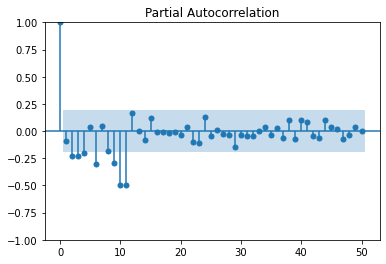

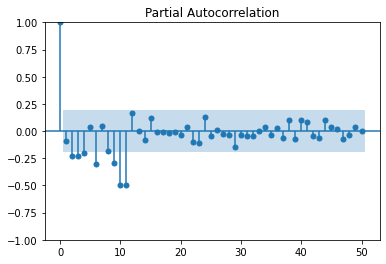

In [14]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(s_monthly_diff1, lags=50, method= "ywm")

We see the first significant lag at 2. Therefore, we set q=2.
order=(p:2, d:1, q:2). Now fit the mathematical equation of the model.

In [15]:
model = ARIMA(s_monthly, order = (2,1,2))
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  107
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -571.046
Date:                Tue, 08 Nov 2022   AIC                           1152.092
Time:                        18:48:08   BIC                           1165.409
Sample:                    01-01-2014   HQIC                          1157.489
                         - 11-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2289      0.230     -0.995      0.320      -0.680       0.222
ar.L2          0.2518      0.204      1.232      0.218      -0.149       0.653
ma.L1         -0.1480      0.163     -0.906      0.365      -0.468       0.172
ma.L2         -0.7810      0.172     -4.530      0.000      -1.119      -0.443
sigma2      2750.4782    425.027      6.471      0.000    1917.440    3583.517
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 4.04
Prob(Q):                              0.93   Prob(JB):                         0.13
Heteroskedasticity (H):               0.76   Skew:                             0.40
Prob(H) (two-sided):                  0.41   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

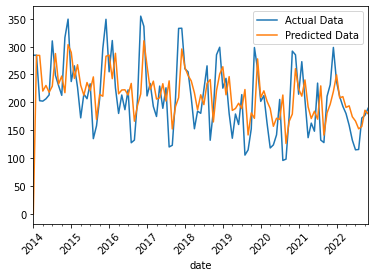

In [16]:
# Calculate the prediction
plt.figure(figsize=(6,4))
s_monthly.plot(label='Actual Data')
result.predict().plot(label='Predicted Data')
plt.legend()
plt.xticks(rotation=45)
plt.savefig('plot.jpg', dpi=150)